# Turkey Earthquake Prediction with Deep Learning Algorithm Master Project

## Import Libraries & Framework

In [1]:
import numpy as np
import pandas as pd
from ydata_profiling import ProfileReport
from tqdm import tqdm
import os

from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import GRU
from keras.layers import LSTM
from keras.layers import SimpleRNN
from keras.layers import Bidirectional

from keras.preprocessing.sequence import TimeseriesGenerator
from keras.callbacks import ModelCheckpoint

from sklearn.metrics import mean_squared_error, mean_absolute_error
from statsmodels.graphics.tsaplots import plot_acf

from src.utils import get_project_config

import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings(action="ignore")

In [2]:
%matplotlib inline

## Load Project Config & Set Variables

In [3]:
# Load Project Config
project_cfg = get_project_config("config.json",)
project_cfg

{'data': {'folderName': 'data',
  'rawData': 'data/raw',
  'processedData': 'data/processed',
  'resultData': 'data/result'},
 'reports': {'folderName': 'reports'},
 'models': {'folderName': 'models'}}

In [4]:
# Set Constant Variables

RAW_DATA_PATH = project_cfg["data"]["rawData"]
# RAW_DATA_PATH

PREPROCESSED_DATA_PATH = project_cfg["data"]["processedData"]
# PREPROCESSED_DATA_PATH

RESULT_DATA_PATH = project_cfg["data"]["resultData"]
# RESULT_DATA_PATH

REPORTS_PATH = project_cfg["reports"]["folderName"]
# REPORTS_PATH

MODELS_PATH = project_cfg["models"]["folderName"]
# MODELS_PATH

In [5]:
# Create Some Directories
os.makedirs(name=MODELS_PATH, exist_ok=True)
os.makedirs(name=REPORTS_PATH, exist_ok=True)

## Data Load

In [6]:
# Read Data
df_data = pd.read_csv(os.path.join(RAW_DATA_PATH, "TurkeyEarthquakeData.xls"))
df_data

,time,Latitude,Longitude,Depth,Source No 2,Source Description 2,Type,Magnitude,Source No 3,Source Description 3
0,10/14/2018 15:08,36.8578,44.4161,16.97,7,AFAD-DDA,Mw,4.0,7,AFAD-DDA
1,10/10/2018 9:08,37.4341,35.8520,7.02,7,AFAD-DDA,Mw,4.1,7,AFAD-DDA
2,10/2/2018 15:29,37.6878,37.4016,10.27,7,AFAD-DDA,Mw,4.4,7,AFAD-DDA
3,9/28/2018 0:26,37.2003,30.4376,78.07,7,AFAD-DDA,Mw,4.0,7,AFAD-DDA
4,9/26/2018 2:52,35.6846,26.7266,42.77,7,AFAD-DDA,Mw,4.5,7,AFAD-DDA
...,...,...,...,...,...,...,...,...,...,...
6569,2/6/1900 15:09,38.1200,31.2900,10.00,2,Ambraseys-Finkel 1987,MS,5.7,2,Ambraseys-Finkel 1987
6570,1/30/1900 1:00,37.8300,27.7100,10.00,2,Ambraseys-Finkel 1987,MS,4.4,2,Ambraseys-Finkel 1987
6571,1/27/1900 2:30,37.6300,37.3700,10.00,2,Ambraseys-Finkel 1987,MS,4.8,2,Ambraseys-Finkel 1987
6572,1/24/1900 3:00,39.5400,26.1400,10.00,2,Ambraseys-Finkel 1987,MS,5.2,2,Ambraseys-Finkel 1987


In [7]:
# Show Data Shape Info
df_data.shape

(6574, 10)

In [8]:
# Show Data Information
df_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6574 entries, 0 to 6573
Data columns (total 10 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   time                  6574 non-null   object 
 1   Latitude              6574 non-null   float64
 2   Longitude             6574 non-null   float64
 3   Depth                 6574 non-null   float64
 4   Source No 2           6574 non-null   int64  
 5   Source Description 2  6574 non-null   object 
 6   Type                  6574 non-null   object 
 7   Magnitude             6574 non-null   float64
 8   Source No 3           6574 non-null   int64  
 9   Source Description 3  6574 non-null   object 
dtypes: float64(4), int64(2), object(4)
memory usage: 513.7+ KB


In [9]:
# Copy df_data
df_data_original = df_data.copy()

In [10]:
# Choose Using features
df_data = df_data[['time', 'Latitude', 'Longitude', 'Depth', 'Magnitude' ]]

In [11]:
# Rename Column Name & Convert Datetime Format
df_data.rename(columns={'time':'Time'}, inplace=True)
df_data

df_data['Time'] = pd.to_datetime(df_data['Time'])
df_data['Time'] = df_data['Time'].dt.strftime('%Y-%m-%d %H:%M:%S')
df_data

,Time,Latitude,Longitude,Depth,Magnitude
0,2018-10-14 15:08:00,36.8578,44.4161,16.97,4.0
1,2018-10-10 09:08:00,37.4341,35.8520,7.02,4.1
2,2018-10-02 15:29:00,37.6878,37.4016,10.27,4.4
3,2018-09-28 00:26:00,37.2003,30.4376,78.07,4.0
4,2018-09-26 02:52:00,35.6846,26.7266,42.77,4.5
...,...,...,...,...,...
6569,1900-02-06 15:09:00,38.1200,31.2900,10.00,5.7
6570,1900-01-30 01:00:00,37.8300,27.7100,10.00,4.4
6571,1900-01-27 02:30:00,37.6300,37.3700,10.00,4.8
6572,1900-01-24 03:00:00,39.5400,26.1400,10.00,5.2


In [12]:
# Set Index with Time Column
df_data.set_index('Time', inplace=True)
df_data

,Latitude,Longitude,Depth,Magnitude
Time,,,,
2018-10-14 15:08:00,36.8578,44.4161,16.97,4.0
2018-10-10 09:08:00,37.4341,35.8520,7.02,4.1
2018-10-02 15:29:00,37.6878,37.4016,10.27,4.4
2018-09-28 00:26:00,37.2003,30.4376,78.07,4.0
2018-09-26 02:52:00,35.6846,26.7266,42.77,4.5
...,...,...,...,...
1900-02-06 15:09:00,38.1200,31.2900,10.00,5.7
1900-01-30 01:00:00,37.8300,27.7100,10.00,4.4
1900-01-27 02:30:00,37.6300,37.3700,10.00,4.8


In [13]:
# Sort Data with Index
df_data.sort_index(inplace=True)
df_data

,Latitude,Longitude,Depth,Magnitude
Time,,,,
1900-01-18 15:30:00,37.7900,28.2100,10.00,4.4
1900-01-24 03:00:00,39.5400,26.1400,10.00,5.2
1900-01-27 02:30:00,37.6300,37.3700,10.00,4.8
1900-01-30 01:00:00,37.8300,27.7100,10.00,4.4
1900-02-06 15:09:00,38.1200,31.2900,10.00,5.7
...,...,...,...,...
2018-09-26 02:52:00,35.6846,26.7266,42.77,4.5
2018-09-28 00:26:00,37.2003,30.4376,78.07,4.0
2018-10-02 15:29:00,37.6878,37.4016,10.27,4.4


In [14]:
# Remove Duplicate Rows
df_data = df_data[~df_data.index.duplicated(keep='first')]
df_data

,Latitude,Longitude,Depth,Magnitude
Time,,,,
1900-01-18 15:30:00,37.7900,28.2100,10.00,4.4
1900-01-24 03:00:00,39.5400,26.1400,10.00,5.2
1900-01-27 02:30:00,37.6300,37.3700,10.00,4.8
1900-01-30 01:00:00,37.8300,27.7100,10.00,4.4
1900-02-06 15:09:00,38.1200,31.2900,10.00,5.7
...,...,...,...,...
2018-09-26 02:52:00,35.6846,26.7266,42.77,4.5
2018-09-28 00:26:00,37.2003,30.4376,78.07,4.0
2018-10-02 15:29:00,37.6878,37.4016,10.27,4.4


In [15]:
# Index convert type to DateTime Object
df_data.index = pd.DatetimeIndex(df_data.index)
df_data

,Latitude,Longitude,Depth,Magnitude
Time,,,,
1900-01-18 15:30:00,37.7900,28.2100,10.00,4.4
1900-01-24 03:00:00,39.5400,26.1400,10.00,5.2
1900-01-27 02:30:00,37.6300,37.3700,10.00,4.8
1900-01-30 01:00:00,37.8300,27.7100,10.00,4.4
1900-02-06 15:09:00,38.1200,31.2900,10.00,5.7
...,...,...,...,...
2018-09-26 02:52:00,35.6846,26.7266,42.77,4.5
2018-09-28 00:26:00,37.2003,30.4376,78.07,4.0
2018-10-02 15:29:00,37.6878,37.4016,10.27,4.4


In [16]:
# Show Data Information
df_data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 6572 entries, 1900-01-18 15:30:00 to 2018-10-14 15:08:00
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Latitude   6572 non-null   float64
 1   Longitude  6572 non-null   float64
 2   Depth      6572 non-null   float64
 3   Magnitude  6572 non-null   float64
dtypes: float64(4)
memory usage: 256.7 KB


In [17]:
# Show Statistical Information of data
df_data.describe().T

,count,mean,std,min,25%,50%,75%,max
Latitude,6572.0,38.461476,1.634289,35.67,36.991825,38.62075,39.566825,42.3869
Longitude,6572.0,33.085486,6.281031,25.85,27.804600,30.16150,39.258650,45.1495
Depth,6572.0,24.984040,27.761584,0.00,10.000000,13.00000,33.000000,212.0000
Magnitude,6572.0,4.467392,0.485420,4.00,4.100000,4.30000,4.700000,7.9000


### Data Profiling

In [18]:
# Create Small Data Profile
df_data_profile = ProfileReport(df_data, title="Profiling Report", minimal=True)
df_data_profile.to_file(os.path.join(REPORTS_PATH, "TurkeyEarthquake-MinimalDataProfiling.html"))

# Create Data Profile
df_data_profile = ProfileReport(df_data, title="Profiling Report")
df_data_profile.to_file(os.path.join(REPORTS_PATH, "TurkeyEarthquake-DataProfiling.html"))

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

### Data Visualizations

In [19]:
# Set Chart Params
plt.rcParams['figure.figsize'] = (10, 8)
plt.rcParams['font.size'] = 14
plt.style.use('ggplot')

array([<Axes: xlabel='Time'>, <Axes: xlabel='Time'>,
       <Axes: xlabel='Time'>, <Axes: xlabel='Time'>], dtype=object)

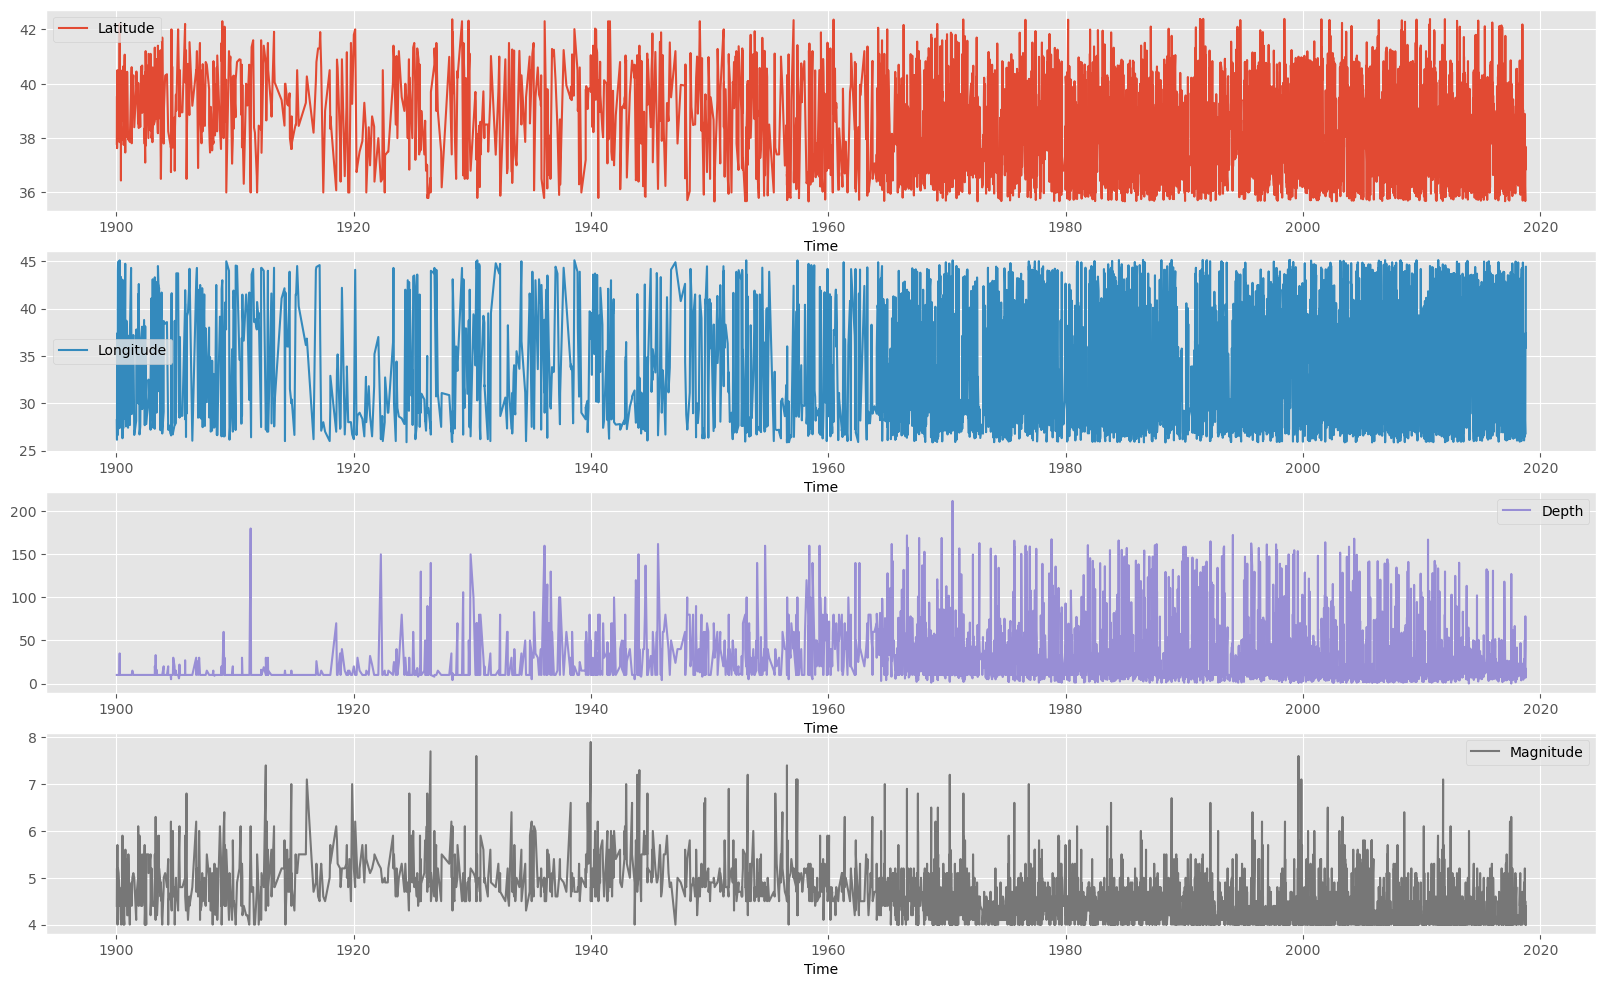

In [20]:
# Visualize Each Columns
df_data.plot(subplots=True, figsize=(20, 12), sharex=False, sharey=False)

In [21]:
# Create Logaritmic Feature for Each Columns 
extended_data = df_data.copy()

for i in extended_data.columns:
    extended_data["Log." + i] = np.log(extended_data[i] + 0.01)

In [22]:
extended_data

,Latitude,Longitude,Depth,Magnitude,Log.Latitude,Log.Longitude,Log.Depth,Log.Magnitude
Time,,,,,,,,
1900-01-18 15:30:00,37.7900,28.2100,10.00,4.4,3.632309,3.340031,2.303585,1.483875
1900-01-24 03:00:00,39.5400,26.1400,10.00,5.2,3.677566,3.263849,2.303585,1.650580
1900-01-27 02:30:00,37.6300,37.3700,10.00,4.8,3.628067,3.621136,2.303585,1.570697
1900-01-30 01:00:00,37.8300,27.7100,10.00,4.4,3.633367,3.322154,2.303585,1.483875
1900-02-06 15:09:00,38.1200,31.2900,10.00,5.7,3.641001,3.443618,2.303585,1.742219
...,...,...,...,...,...,...,...,...
2018-09-26 02:52:00,35.6846,26.7266,42.77,4.5,3.574999,3.286033,3.756071,1.506297
2018-09-28 00:26:00,37.2003,30.4376,78.07,4.0,3.616586,3.416007,4.357734,1.388791
2018-10-02 15:29:00,37.6878,37.4016,10.27,4.4,3.629602,3.621981,2.330200,1.483875


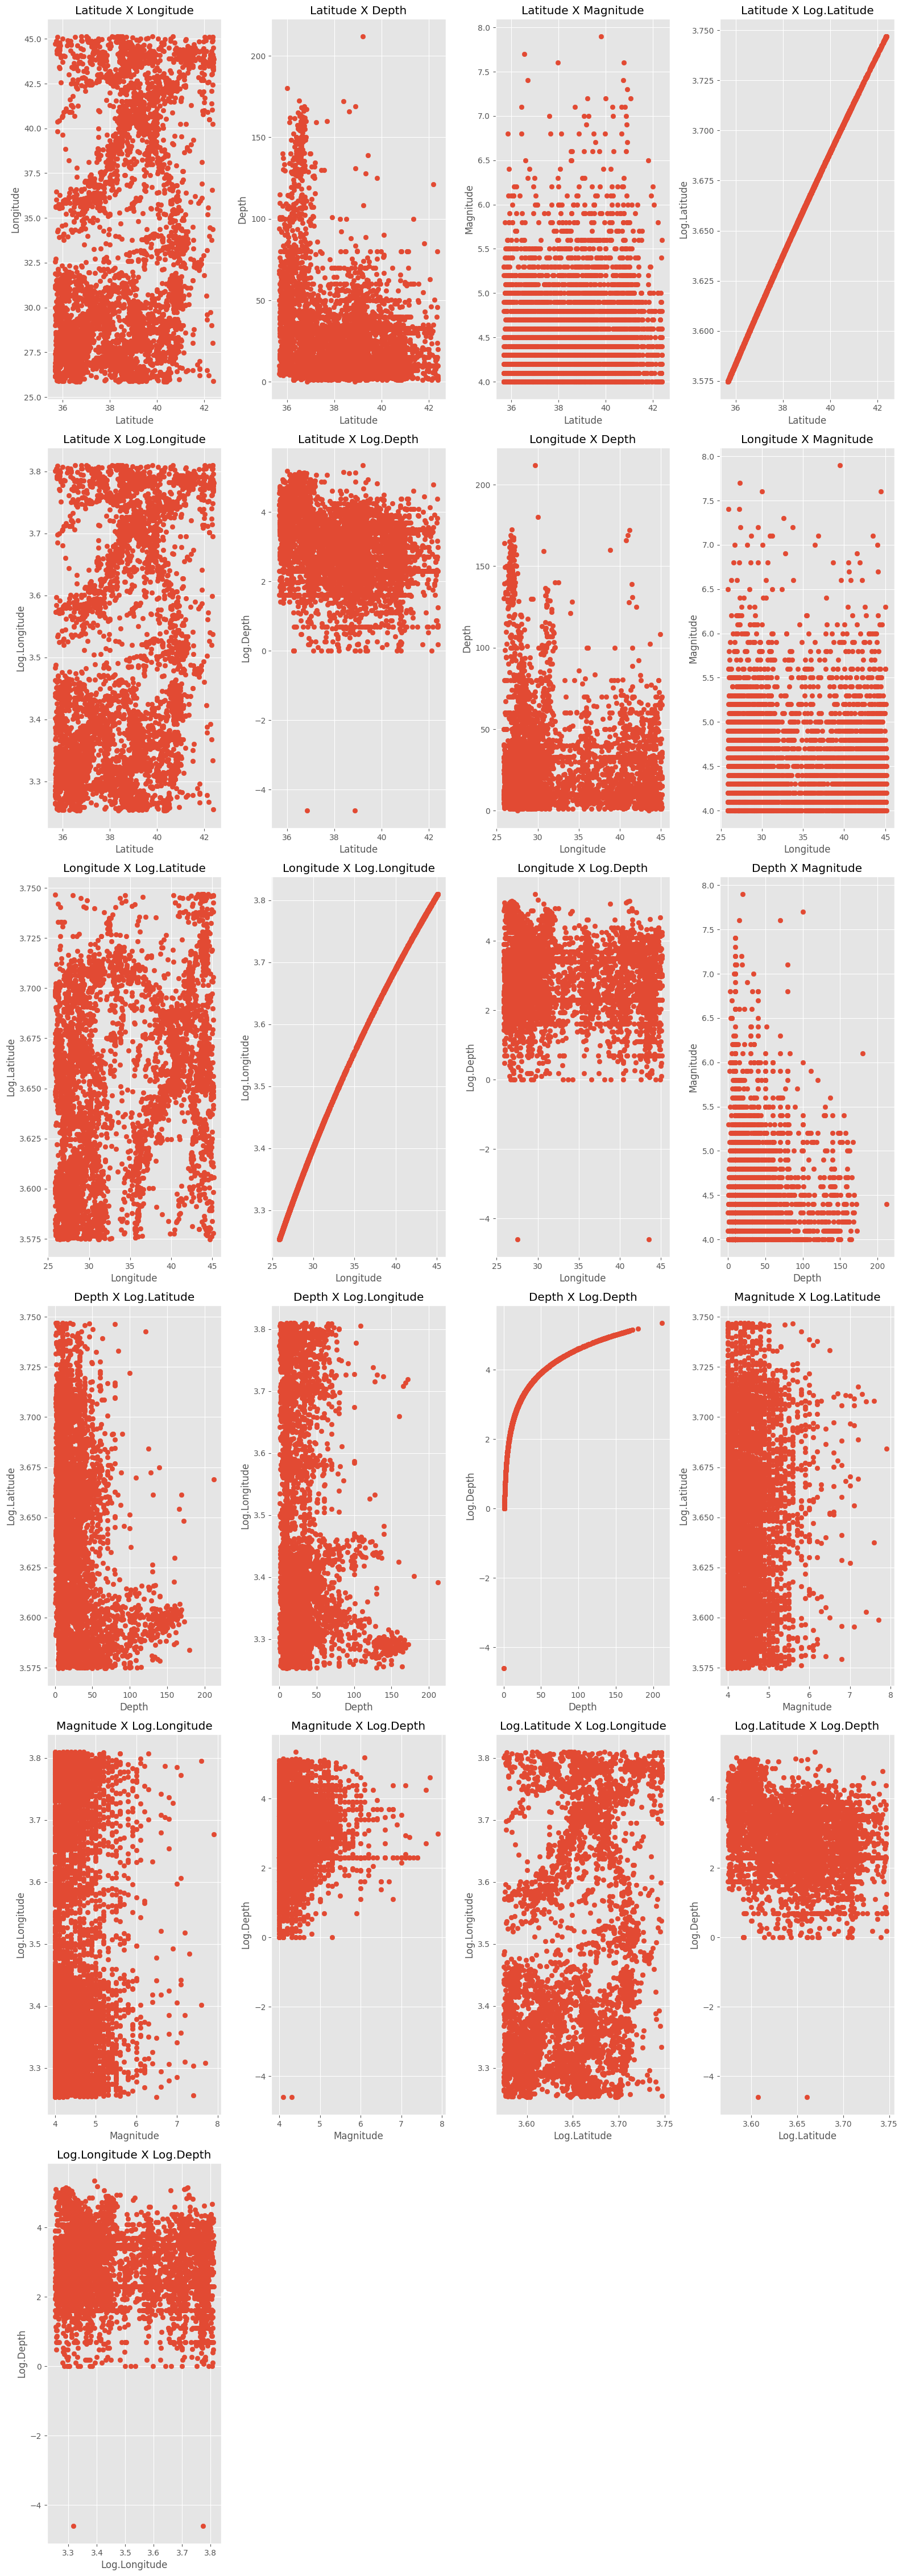

In [23]:
# Visualize Scatter Plot for Each Columns
lines = int(((len(extended_data.columns) - 1) * (len(extended_data.columns))) / 8) + 1
k = 1
subplt = plt.figure(figsize=(16, 60))

for i in range(0, len(extended_data.columns) - 1):
    for j in range(i + 1, len(extended_data.columns) - 1):
        subplt.add_subplot(lines, 4, k)
        plt.scatter(extended_data[extended_data.columns[i]], extended_data[extended_data.columns[j]])
        plt.title("{} X {}".format(extended_data.columns[i], extended_data.columns[j]))
        plt.xlabel(extended_data.columns[i])
        plt.ylabel(extended_data.columns[j])
        k += 1

plt.tight_layout()
plt.show()

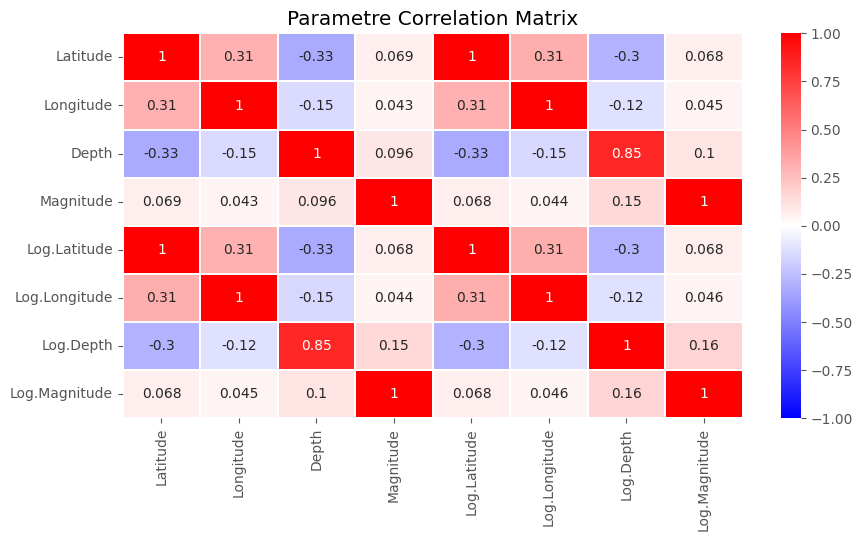

In [24]:
# Visualize Correlation Matrix

extended_corr = extended_data.corr()

plt.figure(figsize=(10, 5))
sns.heatmap(extended_corr, vmin=-1, vmax=1, cmap="bwr", annot=True, linewidth=0.1)
plt.title("Parametre Correlation Matrix")
plt.show()

Text(0.5, 1.0, 'Depth')

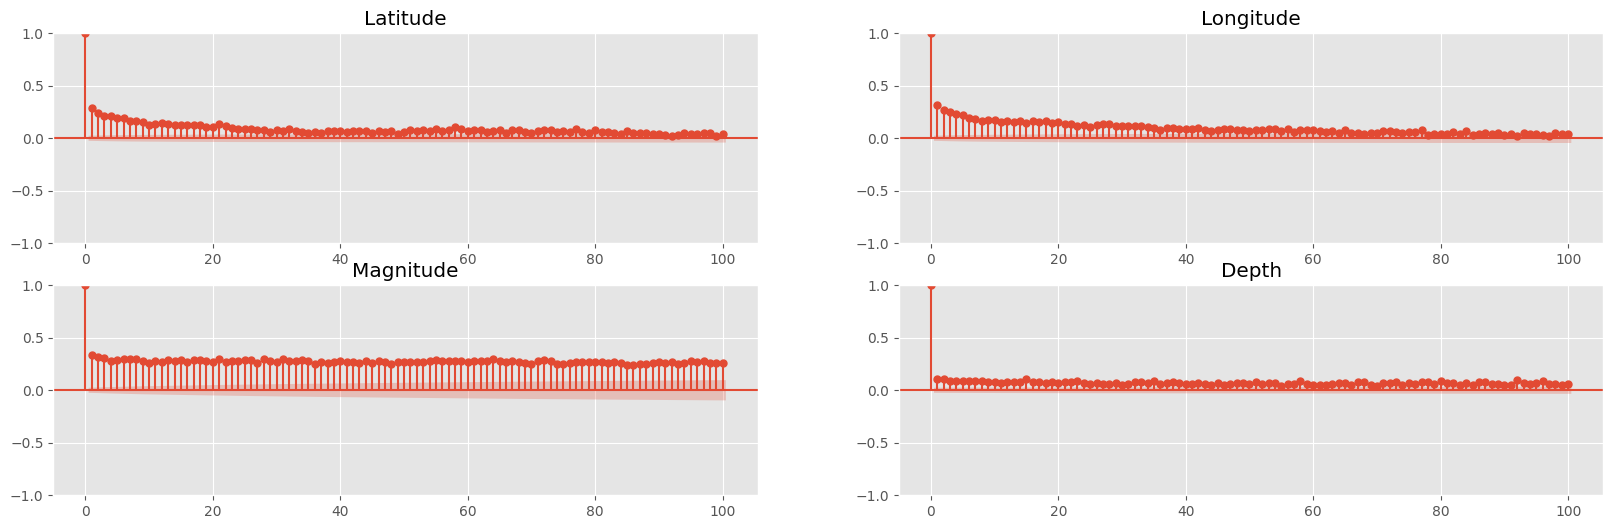

In [25]:
# Visualize ACF Chart

fig, ax = plt.subplots(2, 2, figsize=(20, 6))
plot_acf(df_data['Latitude'], ax=ax[0, 0], lags=100, title='Latitude')
ax[0, 0].set_title('Latitude')
plot_acf(df_data['Longitude'], ax=ax[0, 1], lags=100, title='Longitude')
ax[0, 1].set_title('Longitude')
plot_acf(df_data['Magnitude'], ax=ax[1, 0], lags=100, title='Magnitude')
ax[1, 0].set_title('Magnitude')
plot_acf(df_data['Depth'], ax=ax[1, 1], lags=100, title='Depth')
ax[1, 1].set_title('Depth')

In [26]:
df_data

,Latitude,Longitude,Depth,Magnitude
Time,,,,
1900-01-18 15:30:00,37.7900,28.2100,10.00,4.4
1900-01-24 03:00:00,39.5400,26.1400,10.00,5.2
1900-01-27 02:30:00,37.6300,37.3700,10.00,4.8
1900-01-30 01:00:00,37.8300,27.7100,10.00,4.4
1900-02-06 15:09:00,38.1200,31.2900,10.00,5.7
...,...,...,...,...
2018-09-26 02:52:00,35.6846,26.7266,42.77,4.5
2018-09-28 00:26:00,37.2003,30.4376,78.07,4.0
2018-10-02 15:29:00,37.6878,37.4016,10.27,4.4


### Data Splitting

In [27]:
# Split Data for Train & Test

df_train_data = df_data.iloc[:6000]
df_test_data = df_data.iloc[6000 - 12:]
df_test_original = df_data.iloc[6000:]

N_INPUT = 12
N_FEATURES = 4
BATCH_SIZE = 1
EPOCH_SIZE = 500

In [28]:
df_train_data

,Latitude,Longitude,Depth,Magnitude
Time,,,,
1900-01-18 15:30:00,37.7900,28.2100,10.00,4.4
1900-01-24 03:00:00,39.5400,26.1400,10.00,5.2
1900-01-27 02:30:00,37.6300,37.3700,10.00,4.8
1900-01-30 01:00:00,37.8300,27.7100,10.00,4.4
1900-02-06 15:09:00,38.1200,31.2900,10.00,5.7
...,...,...,...,...
2012-11-30 02:32:00,37.2087,28.6405,20.27,4.2
2012-12-01 03:51:00,37.4735,38.3485,17.86,4.1
2012-12-02 19:02:00,36.6298,27.9543,4.05,4.0


In [29]:
df_test_data

,Latitude,Longitude,Depth,Magnitude
Time,,,,
2012-11-24 16:04:00,38.8330,43.5725,17.53,4.5
2012-11-24 21:04:00,36.6002,27.9387,11.66,4.3
2012-11-24 21:31:00,36.5883,27.9277,20.59,4.2
2012-11-24 21:35:00,36.6172,27.9445,4.45,4.1
2012-11-25 08:51:00,36.5958,27.9220,10.77,4.0
...,...,...,...,...
2018-09-26 02:52:00,35.6846,26.7266,42.77,4.5
2018-09-28 00:26:00,37.2003,30.4376,78.07,4.0
2018-10-02 15:29:00,37.6878,37.4016,10.27,4.4


In [30]:
# Show Shape of Dataframes 
df_train_data.shape, df_test_data.shape, df_test_original.shape

((6000, 4), (584, 4), (572, 4))

In [31]:
# Create TimeSeriesGenerator for Training Data
train_generator = TimeseriesGenerator(df_train_data.values, df_train_data.values, length=N_INPUT, batch_size=BATCH_SIZE)

In [32]:
# Create TimeSeriesGenerator for Test Data
test_generator = TimeseriesGenerator(df_test_data.values, df_test_data.values, length=N_INPUT, batch_size=BATCH_SIZE)

In [33]:
# Split Train and Test Data
train_x = np.array([])
train_y = np.array([])
test_x = np.array([])
test_y = np.array([])

for i in range(len(train_generator)):
    a, b = train_generator[i]
    train_x = np.append(train_x, a.flatten())
    train_y = np.append(train_y, b)

for i in range(len(test_generator)):
    a, b = test_generator[i]
    test_x = np.append(test_x, a.flatten())
    test_y = np.append(test_y, b)

In [34]:
# Reshape Data Dimension Shape
train_x = train_x.reshape(-1, N_FEATURES, N_INPUT)
train_y = train_y.reshape(-1, N_FEATURES)
test_x = test_x.reshape(-1, N_FEATURES, N_INPUT)
test_y = test_y.reshape(-1, N_FEATURES)

In [35]:
# Show the shape of the Train & Test Data
print(train_x.shape, train_y.shape)
print(test_x.shape, test_y.shape)

(5988, 4, 12) (5988, 4)
(572, 4, 12) (572, 4)


## Model Selection & Training

### LSTM Model

In [36]:
# Create LSTM Model Architecture
model_lstm = Sequential()
model_lstm.add(LSTM(64, activation='tanh', input_shape=(N_FEATURES, N_INPUT), return_sequences=True))
model_lstm.add(LSTM(32, activation='tanh', input_shape=(N_FEATURES, N_INPUT), return_sequences=False))
model_lstm.add(Dense(32, activation='elu'))
model_lstm.add(Dense(16, activation='gelu'))
model_lstm.add(Dense(train_y.shape[1]))
model_lstm.compile(optimizer='adam', loss='mse')
model_lstm.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 4, 64)             19712     
                                                                 
 lstm_1 (LSTM)               (None, 32)                12416     
                                                                 
 dense (Dense)               (None, 32)                1056      
                                                                 
 dense_1 (Dense)             (None, 16)                528       
                                                                 
 dense_2 (Dense)             (None, 4)                 68        
                                                                 
Total params: 33780 (131.95 KB)
Trainable params: 33780 (131.95 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [37]:
# Create Directory for LSTM Model 
MODEL_DIR = project_cfg["models"]["folderName"]
MODEL_PATH = os.path.join(MODEL_DIR, "LSTM")

os.makedirs(name=MODEL_PATH, exist_ok=True)

In [38]:
# Delete all previously saved model files
for i in os.listdir(MODEL_PATH):
    file_path = os.path.join(MODEL_PATH, i)
    try:
        if os.path.isfile(file_path):
            os.unlink(file_path)
    except Exception as e:
        print(e)

In [39]:
# Save Model Weight per Epoch

model_dir_per_epoch = os.path.join(MODEL_PATH, 'weights-improvement-{epoch:02d}-{val_loss:.2f}.hdf5')
checkpoint = ModelCheckpoint(model_dir_per_epoch, 
                             monitor='val_loss', 
                             save_best_only=False,
                             verbose=0)

callbacks = [checkpoint]

In [40]:
# Train LSTM Model 

history = {'loss':[], 'val_loss':[]}

with tqdm(total=EPOCH_SIZE) as pbar:
    for i in range(EPOCH_SIZE):
        h = model_lstm.fit(train_x, train_y,
                           epochs=1,
                           batch_size=16,
                           validation_split=0.1,
                           callbacks=callbacks,
                           shuffle=False,
                           verbose=0)
        history['loss'].append(h.history['loss'])
        history['val_loss'].append(h.history['val_loss'])
        pbar.update(1)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [15:40<00:00,  1.88s/it]


Last Epoch Values: 
loss:  [21.742916107177734]
val_loss:  [182.13442993164062]


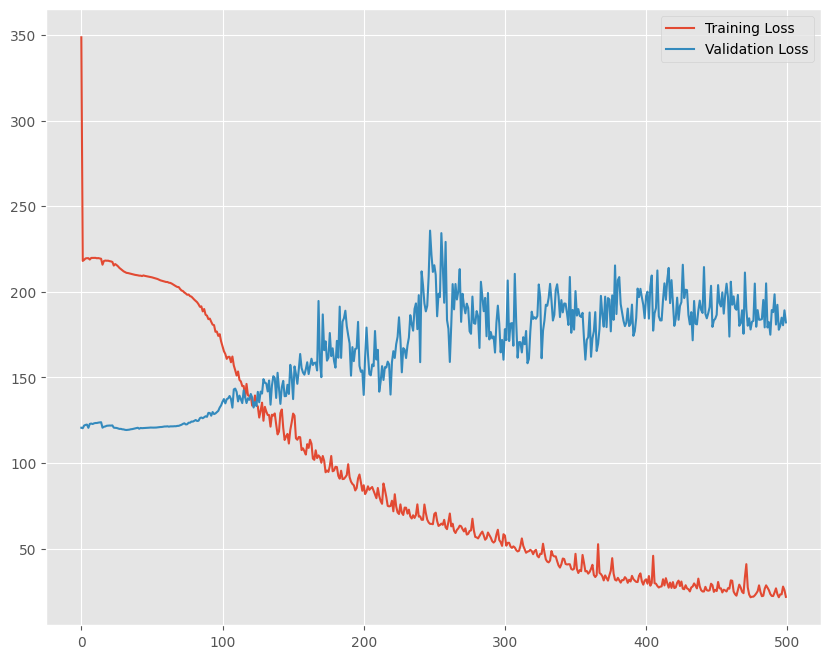

In [41]:
#  Visualization of Loss Values

print('Last Epoch Values: ')
print('loss: ', history['loss'][-1])
print('val_loss: ', history['val_loss'][-1])

loss_per_epoch = history['loss']
val_loss_per_epoch = history['val_loss']

# Visualizing Loss Values and MAE in each epoch
plt.plot(loss_per_epoch, label='Training Loss')
plt.plot(val_loss_per_epoch, label='Validation Loss')
plt.legend()
plt.show()

In [42]:
# Load Best Performance Model

models_dir = os.path.join(MODEL_PATH, os.listdir(MODEL_PATH)[-5])
model = keras.models.load_model(models_dir)

In [43]:
# Prediction Test Set

predictions = model.predict(test_x)
predictions_lstm = pd.DataFrame(predictions, columns=df_data[['Latitude', 'Longitude', 'Depth', 'Magnitude']].columns, index=df_test_original.index)
predictions_lstm

18/18 [==============================] - 1s 4ms/step


,Latitude,Longitude,Depth,Magnitude
Time,,,,
2012-12-12 01:18:00,37.146000,33.532928,5.453400,4.111352
2012-12-12 07:52:00,38.690018,35.975742,9.995042,4.180329
2012-12-23 06:38:00,37.951180,34.735519,22.873487,4.251297
2012-12-23 07:12:00,38.033062,37.023376,9.354811,4.186078
2012-12-24 04:14:00,38.184277,35.086437,7.101302,4.224852
...,...,...,...,...
2018-09-26 02:52:00,36.919739,30.779707,15.480536,4.146187
2018-09-28 00:26:00,38.002193,31.769154,10.047824,4.217783
2018-10-02 15:29:00,37.223152,32.857018,33.595886,4.264448


In [44]:
# Calculate MSE, RMSE and MAE performance metrics

mse = mean_squared_error(test_y, predictions)
mae = mean_absolute_error(test_y, predictions)
rmse = np.sqrt(mse)
print('MSE: ', mse)
print('RMSE: ', rmse)
print('MAE: ', mae)

MSE:  195.54467682314038
RMSE:  13.983729002778206
MAE:  5.709086328184523


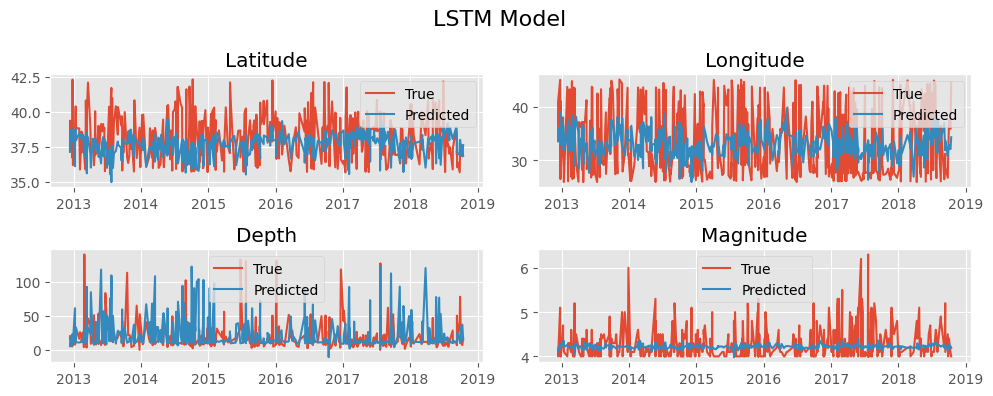

In [46]:
# Compare Actual and Prediction Values

fig, ax = plt.subplots(2, 2, figsize=(10, 4))
for i, col in enumerate(predictions_lstm.columns):
    ax[i//2, i%2].plot(df_test_original[col], label='True')
    ax[i//2, i%2].plot(predictions_lstm[col], label='Predicted')
    ax[i//2, i%2].set_title(col)
    ax[i//2, i%2].legend()
fig.suptitle('LSTM Model', fontsize=16)
plt.tight_layout()

### RNN Model

In [47]:
# Create RNN Model Architecture

model_rnn = Sequential()
model_rnn.add(SimpleRNN(64, activation='tanh', input_shape=(N_FEATURES, N_INPUT), return_sequences=True))
model_rnn.add(SimpleRNN(32, activation='tanh', input_shape=(N_FEATURES, N_INPUT), return_sequences=False))
model_rnn.add(Dense(32, activation='elu'))
model_rnn.add(Dense(16, activation='gelu'))
model_rnn.add(Dense(train_y.shape[1]))
model_rnn.compile(optimizer='adam', loss='mse')

model_rnn.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn (SimpleRNN)      (None, 4, 64)             4928      
                                                                 
 simple_rnn_1 (SimpleRNN)    (None, 32)                3104      
                                                                 
 dense_3 (Dense)             (None, 32)                1056      
                                                                 
 dense_4 (Dense)             (None, 16)                528       
                                                                 
 dense_5 (Dense)             (None, 4)                 68        
                                                                 
Total params: 9684 (37.83 KB)
Trainable params: 9684 (37.83 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [48]:
# Create Directory for RNN Model

MODEL_PATH = os.path.join(MODEL_DIR, "RNN")
os.makedirs(name=MODEL_PATH, exist_ok=True)

In [49]:
# Delete all previously saved model files
for i in os.listdir(MODEL_PATH):
    file_path = os.path.join(MODEL_PATH, i)
    try:
        if os.path.isfile(file_path):
            os.unlink(file_path)
    except Exception as e:
        print(e)

In [50]:
# Save Model Weight per Epoch
model_dir_per_epoch = os.path.join(MODEL_PATH, 'weights-improvement-{epoch:02d}-{val_loss:.2f}.hdf5')
checkpoint = ModelCheckpoint(model_dir_per_epoch, 
                             monitor='val_loss', 
                             save_best_only=False,
                             verbose=0)

callbacks = [checkpoint]

In [51]:
# Train RNN Model

history = {'loss':[], 'val_loss':[]}

with tqdm(total=EPOCH_SIZE) as pbar:
    for i in range(EPOCH_SIZE):
        h = model_rnn.fit(train_x, train_y,
                          epochs=1,
                          batch_size=16,
                          validation_split=0.1,
                          callbacks=callbacks,
                          shuffle=False,
                          verbose=0)
        history['loss'].append(h.history['loss'])
        history['val_loss'].append(h.history['val_loss'])
        pbar.update(1)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [11:50<00:00,  1.42s/it]


In [52]:
# Visualization of Loss Values

print('Last Epoch Values: ')
print('loss: ', history['loss'][-1])
print('val_loss: ', history['val_loss'][-1])

loss_per_epoch = history['loss']
val_loss_per_epoch = history['val_loss']

Last Epoch Values: 
loss:  [152.003173828125]
val_loss:  [138.57521057128906]


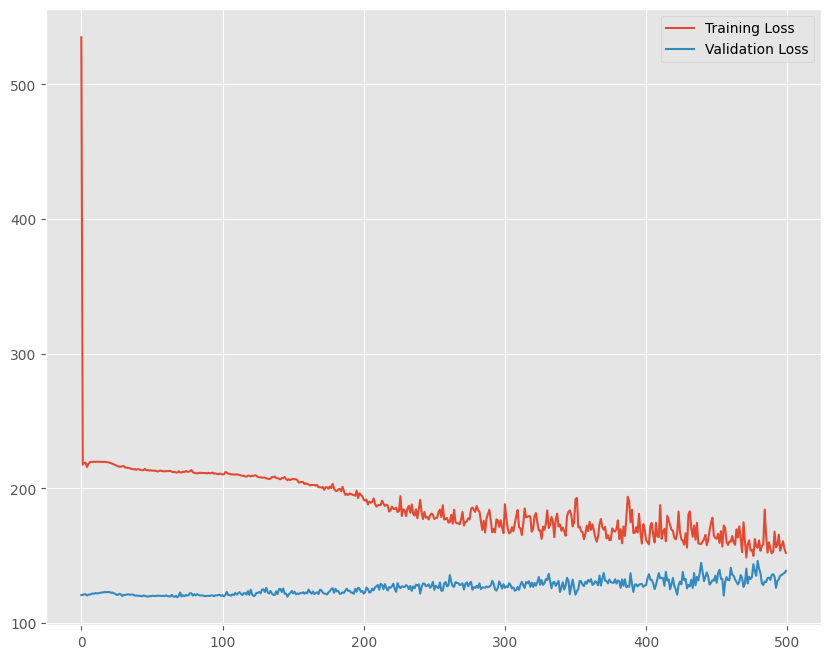

In [53]:
# Visualizing Loss Values and MAE in each epoch

plt.plot(loss_per_epoch, label='Training Loss')
plt.plot(val_loss_per_epoch, label='Validation Loss')
plt.legend()
plt.show()

In [54]:
# Load Best Performance Model

models_dir = os.path.join(MODEL_PATH, os.listdir(MODEL_PATH)[-5])
model = keras.models.load_model(models_dir)

In [55]:
# Prediction Test Set

predictions = model.predict(test_x)
predictions_rnn = pd.DataFrame(predictions, columns=df_data.columns, index=df_test_original.index)
predictions_rnn

18/18 [==============================] - 1s 2ms/step


,Latitude,Longitude,Depth,Magnitude
Time,,,,
2012-12-12 01:18:00,36.932659,32.737831,17.584324,4.097193
2012-12-12 07:52:00,38.156303,33.207909,19.502602,4.232254
2012-12-23 06:38:00,37.963371,32.581890,21.908806,4.234342
2012-12-23 07:12:00,37.859871,33.527348,20.617809,4.157063
2012-12-24 04:14:00,38.142624,33.824783,22.425747,4.232644
...,...,...,...,...
2018-09-26 02:52:00,36.899483,32.597034,23.644497,4.104158
2018-09-28 00:26:00,36.570637,31.418755,63.820347,4.190135
2018-10-02 15:29:00,38.040874,34.496220,27.389809,4.212286


In [56]:
# Calculate MSE, RMSE and MAE performance metrics

mse = mean_squared_error(test_y, predictions)
mae = mean_absolute_error(test_y, predictions)
rmse = np.sqrt(mse)
print('MSE: ', mse)
print('RMSE: ', rmse)
print('MAE: ', mae)

MSE:  95.12687123376699
RMSE:  9.7533005302701
MAE:  4.7005108101517985


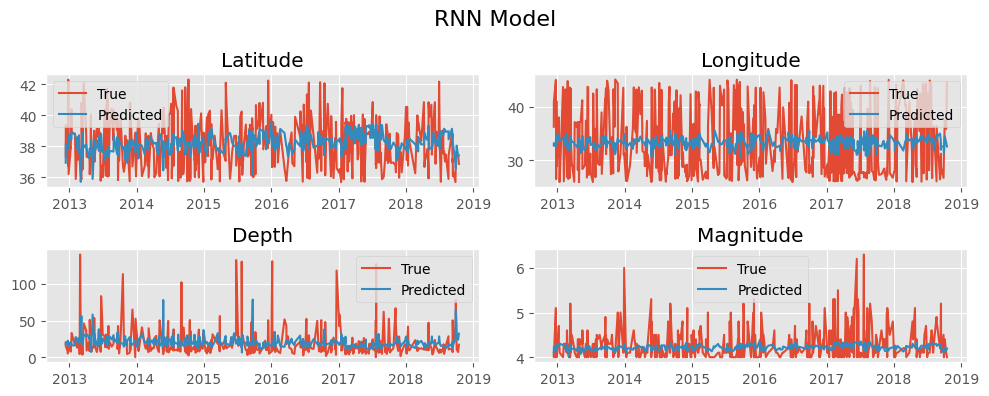

In [57]:
# Compare Actual and Prediction Values

fig, ax = plt.subplots(2, 2, figsize=(10, 4))
for i, col in enumerate(predictions_rnn.columns):
    ax[i//2, i%2].plot(df_test_original[col], label='True')
    ax[i//2, i%2].plot(predictions_rnn[col], label='Predicted')
    ax[i//2, i%2].set_title(col)
    ax[i//2, i%2].legend()
fig.suptitle('RNN Model', fontsize=16)
plt.tight_layout()

### GRU Model

In [58]:
# Create GRU Model Architecture

model_gru = Sequential()
model_gru.add(GRU(64, activation='tanh', input_shape=(N_FEATURES, N_INPUT), return_sequences=True))
model_gru.add(GRU(32, activation='tanh', input_shape=(N_FEATURES, N_INPUT), return_sequences=False))
model_gru.add(Dense(32, activation='elu'))
model_gru.add(Dense(16, activation='gelu'))
model_gru.add(Dense(train_y.shape[1]))

model_gru.compile(optimizer='adam', loss='mse')

model_gru.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru (GRU)                   (None, 4, 64)             14976     
                                                                 
 gru_1 (GRU)                 (None, 32)                9408      
                                                                 
 dense_6 (Dense)             (None, 32)                1056      
                                                                 
 dense_7 (Dense)             (None, 16)                528       
                                                                 
 dense_8 (Dense)             (None, 4)                 68        
                                                                 
Total params: 26036 (101.70 KB)
Trainable params: 26036 (101.70 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [59]:
# Create Directory for GRU Model

MODEL_PATH = os.path.join(MODEL_DIR, "GRU")
os.makedirs(name=MODEL_PATH, exist_ok=True)

In [60]:
# Delete all previously saved model files
for i in os.listdir(MODEL_PATH):
    file_path = os.path.join(MODEL_PATH, i)
    try:
        if os.path.isfile(file_path):
            os.unlink(file_path)
    except Exception as e:
        print(e)

In [61]:
# Save Model Weight per Epoch
model_dir_per_epoch = os.path.join(MODEL_PATH, 'weights-improvement-{epoch:02d}-{val_loss:.2f}.hdf5')
checkpoint = ModelCheckpoint(model_dir_per_epoch, 
                             monitor='val_loss', 
                             save_best_only=False,
                             verbose=0)

callbacks = [checkpoint]

In [62]:
# Train GRU Model

history = {'loss':[], 'val_loss':[]}

with tqdm(total=EPOCH_SIZE) as pbar:
    for i in range(EPOCH_SIZE):
        h = model_gru.fit(train_x, train_y,
                          epochs=1,
                          batch_size=16,
                          validation_split=0.1,
                          callbacks=callbacks,
                          shuffle=False,
                          verbose=0)
        history['loss'].append(h.history['loss'])
        history['val_loss'].append(h.history['val_loss'])
        pbar.update(1)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [20:34<00:00,  2.47s/it]


In [64]:
# Visualization of Loss Values

print('Last Epoch Values: ')
print('loss: ', history['loss'][-1])
print('val_loss: ', history['val_loss'][-1])

loss_per_epoch = history['loss']
val_loss_per_epoch = history['val_loss']

Last Epoch Values: 
loss:  [43.72903060913086]
val_loss:  [178.72537231445312]


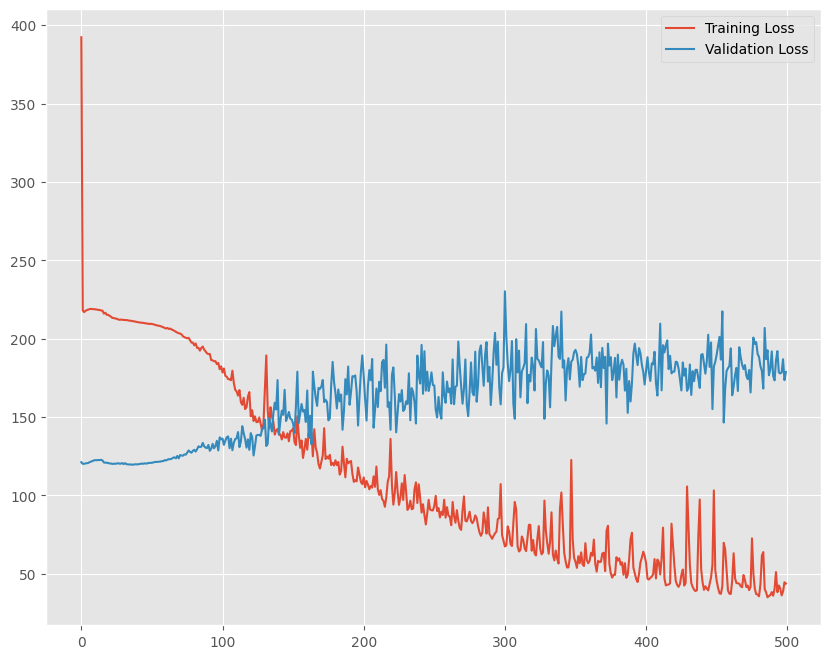

In [65]:
# Visualizing Loss Values and MAE in each epoch

plt.plot(loss_per_epoch, label='Training Loss')
plt.plot(val_loss_per_epoch, label='Validation Loss')
plt.legend()
plt.show()

In [66]:
# Load Best Performance Model

# models_dir = os.path.join(model_dir, os.listdir(model_dir)[-200])
models_dir = os.path.join(MODEL_PATH, os.listdir(MODEL_PATH)[-200])
model = keras.models.load_model(models_dir)

In [67]:
# Prediction Test Set

predictions = model.predict(test_x)
predictions_gru = pd.DataFrame(predictions, columns=df_data.columns, index=df_test_original.index)
predictions_gru

18/18 [==============================] - 1s 6ms/step


,Latitude,Longitude,Depth,Magnitude
Time,,,,
2012-12-12 01:18:00,38.862812,33.634544,7.986919,4.238937
2012-12-12 07:52:00,37.959003,34.622452,13.980484,4.248948
2012-12-23 06:38:00,36.293766,31.908854,58.805447,4.225333
2012-12-23 07:12:00,39.137569,34.345707,12.146329,4.319904
2012-12-24 04:14:00,39.116928,35.028114,7.395171,4.291508
...,...,...,...,...
2018-09-26 02:52:00,38.351795,33.027790,14.007003,4.240160
2018-09-28 00:26:00,38.909618,33.069263,4.796003,4.319419
2018-10-02 15:29:00,38.404655,34.645149,11.936641,4.245641


In [68]:
# Calculate MSE, RMSE and MAE performance metrics

mse = mean_squared_error(test_y, predictions)
mae = mean_absolute_error(test_y, predictions)
rmse = np.sqrt(mse)
print('MSE: ', mse)
print('RMSE: ', rmse)
print('MAE: ', mae)

MSE:  129.06773189581747
RMSE:  11.360798030764277
MAE:  4.9922651193430365


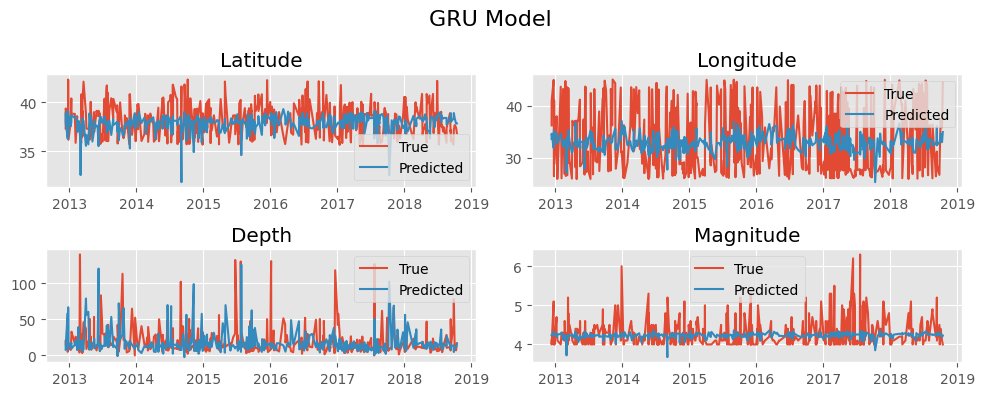

In [69]:
# Compare Actual and Prediction Values

fig, ax = plt.subplots(2, 2, figsize=(10, 4))
for i, col in enumerate(predictions_gru.columns):
    ax[i//2, i%2].plot(df_test_original[col], label='True')
    ax[i//2, i%2].plot(predictions_gru[col], label='Predicted')
    ax[i//2, i%2].set_title(col)
    ax[i//2, i%2].legend()
fig.suptitle('GRU Model', fontsize=16)
plt.tight_layout()

### Bidirectional Model

In [70]:
# Create Bidirectional Model Architecture

model_bid_lstm = Sequential()
model_bid_lstm.add(Bidirectional(LSTM(64, activation='tanh', input_shape=(N_FEATURES, N_INPUT), return_sequences=True)))
model_bid_lstm.add(Bidirectional(LSTM(32, activation='tanh', input_shape=(N_FEATURES, N_INPUT), return_sequences=False)))
model_bid_lstm.add(Dense(32, activation='elu'))
model_bid_lstm.add(Dense(16, activation='gelu'))
model_bid_lstm.add(Dense(train_y.shape[1]))
model_bid_lstm.compile(optimizer='adam', loss='mse')

model_bid_lstm.build(input_shape=(None, N_FEATURES, N_INPUT))
model_bid_lstm.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional (Bidirection  (None, 4, 128)            39424     
 al)                                                             
                                                                 
 bidirectional_1 (Bidirecti  (None, 64)                41216     
 onal)                                                           
                                                                 
 dense_9 (Dense)             (None, 32)                2080      
                                                                 
 dense_10 (Dense)            (None, 16)                528       
                                                                 
 dense_11 (Dense)            (None, 4)                 68        
                                                                 
Total params: 83316 (325.45 KB)
Trainable params: 8331

In [71]:
# Create Directory for Bidirectional Model

MODEL_PATH = os.path.join(MODEL_DIR, "Bidirectional")
os.makedirs(name=MODEL_PATH, exist_ok=True)

In [72]:
# Delete all previously saved model files
for i in os.listdir(MODEL_PATH):
    file_path = os.path.join(MODEL_PATH, i)
    try:
        if os.path.isfile(file_path):
            os.unlink(file_path)
    except Exception as e:
        print(e)

In [73]:
# Save Model Weight per Epoch
model_dir_per_epoch = os.path.join(MODEL_PATH, 'weights-improvement-{epoch:02d}-{val_loss:.2f}.hdf5')
checkpoint = ModelCheckpoint(model_dir_per_epoch, 
                             monitor='val_loss', 
                             save_best_only=False,
                             verbose=0)

callbacks = [checkpoint]

In [74]:
# Train Bidirectional Model
history = {'loss':[], 'val_loss':[]}

with tqdm(total=EPOCH_SIZE) as pbar:
    for i in range(EPOCH_SIZE):
        h = model_bid_lstm.fit(train_x, train_y,
                               epochs=1,
                               batch_size=16,
                               validation_split=0.1,
                               callbacks=callbacks,
                               shuffle=False,
                               verbose=0)
        history['loss'].append(h.history['loss'])
        history['val_loss'].append(h.history['val_loss'])
        pbar.update(1)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [39:13<00:00,  4.71s/it]


In [75]:
# Visualization of Loss Values

print('Last Epoch Values: ')
print('loss: ', history['loss'][-1])
print('val_loss: ', history['val_loss'][-1])

loss_per_epoch = history['loss']
val_loss_per_epoch = history['val_loss']

Last Epoch Values: 
loss:  [5.428692817687988]
val_loss:  [165.990966796875]


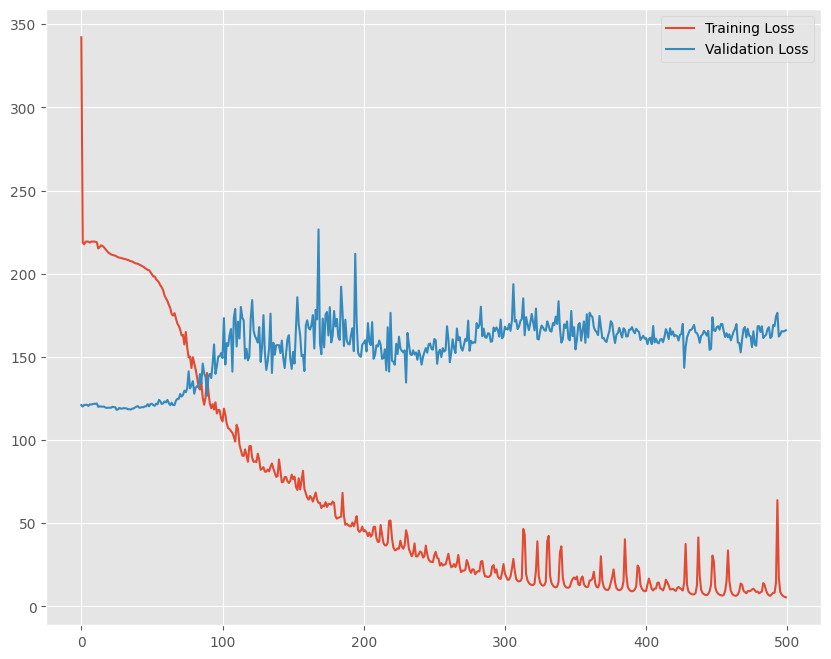

In [76]:
# Visualizing Loss Values and MAE in each epoch

plt.plot(loss_per_epoch, label='Training Loss')
plt.plot(val_loss_per_epoch, label='Validation Loss')
plt.legend()
plt.show()

In [77]:
# Load Best Performance Model

# models_dir = os.path.join(model_dir, os.listdir(model_dir)[-10])
models_dir = os.path.join(MODEL_PATH, os.listdir(MODEL_PATH)[-10])
model = keras.models.load_model(models_dir)

In [78]:
# Prediction Test Set

predictions = model.predict(test_x)
predictions_bid_lstm = pd.DataFrame(predictions, columns=df_data.columns, index=df_test_original.index)
predictions_bid_lstm

18/18 [==============================] - 2s 8ms/step


,Latitude,Longitude,Depth,Magnitude
Time,,,,
2012-12-12 01:18:00,37.885109,33.441189,10.396325,4.209733
2012-12-12 07:52:00,37.525841,30.867777,10.593569,4.142697
2012-12-23 06:38:00,38.669472,34.307514,21.571554,4.356745
2012-12-23 07:12:00,38.953831,36.297211,12.378557,4.311018
2012-12-24 04:14:00,38.906708,35.509312,12.865998,4.373772
...,...,...,...,...
2018-09-26 02:52:00,38.773201,31.811024,22.943619,4.383112
2018-09-28 00:26:00,36.907143,30.875370,23.960873,4.257134
2018-10-02 15:29:00,36.241234,29.454359,48.656467,4.245176


In [79]:
# Calculate MSE, RMSE and MAE performance metrics

mse = mean_squared_error(test_y, predictions)
mae = mean_absolute_error(test_y, predictions)
rmse = np.sqrt(mse)
print('MSE: ', mse)
print('RMSE: ', rmse)
print('MAE: ', mae)

MSE:  156.4880155326572
RMSE:  12.509516998375965
MAE:  5.2522716084096785


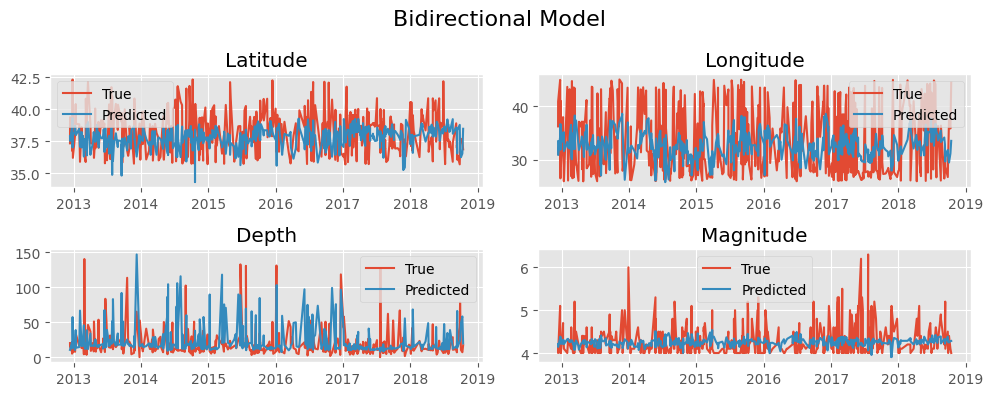

In [80]:
# Compare Actual and Prediction Values

fig, ax = plt.subplots(2, 2, figsize=(10, 4))
for i, col in enumerate(predictions_bid_lstm.columns):
    ax[i//2, i%2].plot(df_test_original[col], label='True')
    ax[i//2, i%2].plot(predictions_bid_lstm[col], label='Predicted')
    ax[i//2, i%2].set_title(col)
    ax[i//2, i%2].legend()
fig.suptitle('Bidirectional Model', fontsize=16)
plt.tight_layout()

### Evaluating Models Output

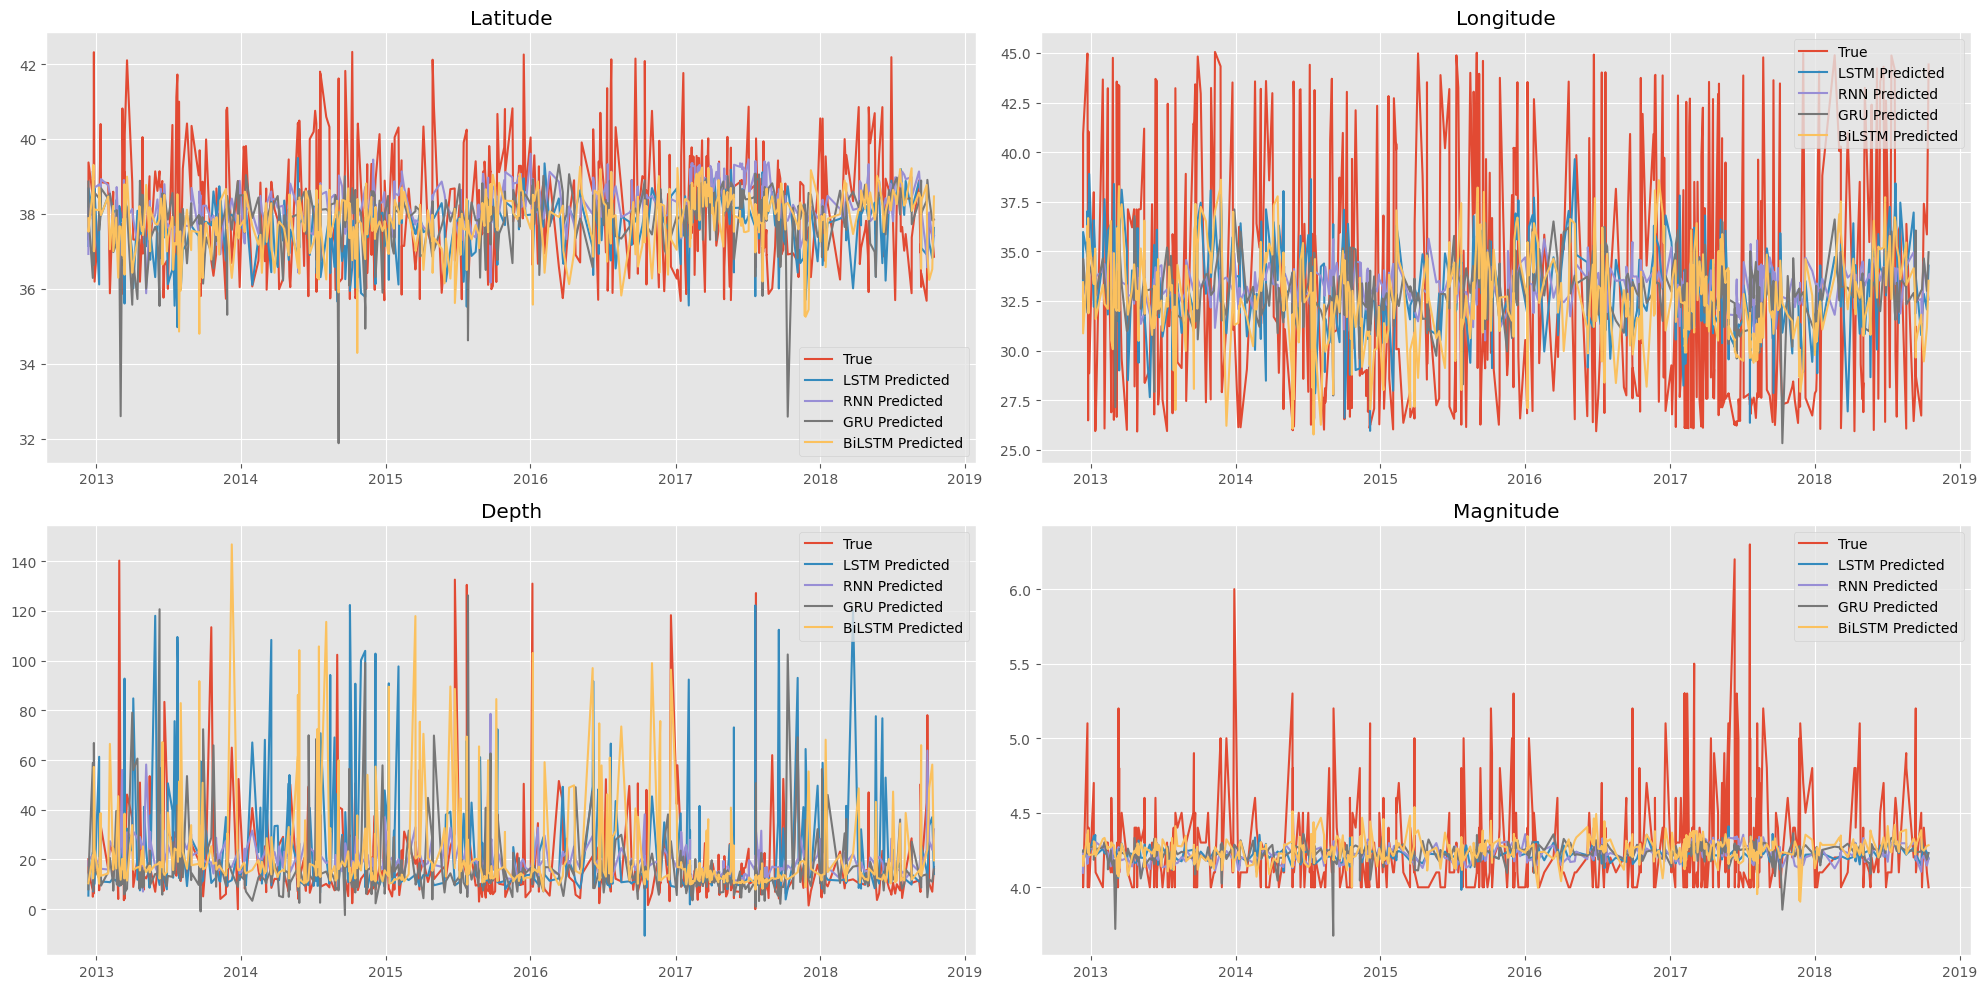

In [81]:
fig, ax = plt.subplots(2, 2, figsize=(20, 10))
for i, col in enumerate(predictions_gru.columns):
    ax[i//2, i%2].plot(df_test_original[col], label='True')
    ax[i//2, i%2].plot(predictions_lstm[col], label='LSTM Predicted')
    ax[i//2, i%2].plot(predictions_rnn[col], label='RNN Predicted')
    ax[i//2, i%2].plot(predictions_gru[col], label='GRU Predicted')
    ax[i//2, i%2].plot(predictions_bid_lstm[col], label='BiLSTM Predicted')
    ax[i//2, i%2].set_title(col)
    ax[i//2, i%2].legend()
plt.tight_layout()